In [1]:
!ls
!pwd
!nvidia-smi

F_MNIST_data	     data_check.py	numpy_array_save
ML_Train_Game.ipynb  exam_Lenet5.ipynb	train_record
/home/student/Thesis-Kantorovich
Fri Jan 19 14:49:07 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.05    Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  Off |
|  0%   35C    P8    14W / 450W |      0MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+-

# Connect Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import os
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import torch.nn.init as init
import torch.nn.functional as F

/home/student/anaconda3/envs/Thesis-Kantorovich/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Congestion NN

In [29]:
class Congestion(nn.Module):
    def __init__(self, input_size, output_size):
        super(Congestion, self).__init__()
        self.fc00 = nn.Linear(input_size, 1024)
        self.bn00 = nn.BatchNorm1d(1024)
        self.fc0 = nn.Linear(1024, 512)
        self.bn0 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.fc5 = nn.Linear(32,  output_size)

        self.init_weights()

    def forward(self, x):
        x = F.relu(self.bn00(self.fc00(x)))
        x = F.relu(self.bn0(self.fc0(x)))
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn4(self.fc4(x)))
        x = F.relu(self.fc5(x))
        return x

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # init.normal_(m.weight, mean=0, std=1.0)
                init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

# Shallow Congestion

In [4]:
class Shallow_Congestion(nn.Module):
    def __init__(self, input_size, output_size):
        super(Shallow_Congestion, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.fc4 = nn.Linear(16, output_size)  # Output layer with 1 neuron for beta prediction
        self.init_weights()

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.fc4(x))
        return x

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # init.normal_(m.weight, mean=0, std=1.0)
                init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

# Dynamic Attention Regression

In [85]:
class DynamicQuadraticNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(DynamicQuadraticNet, self).__init__()
        # Define layers
        self.linear1 = nn.Linear(input_size, 4096)
        self.bn1 = nn.BatchNorm1d(4096)
        self.attention1 = nn.Linear(4096, 1, bias=False)

        self.linear2 = nn.Linear(4096, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.attention2 = nn.Linear(1024, 1, bias=False)

        self.linear3 = nn.Linear(1024, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.attention3 = nn.Linear(32, 1, bias=False)

        self.linear5 = nn.Linear(32, output_size)

    def forward(self, x):
        # Linear transformation
        x = torch.relu(self.bn1(self.linear1(x)))
        # Attention mechanism
        attention_scores_1 = torch.softmax(self.attention1(x), dim=1)
        x = attention_scores_1 * x

        x = torch.relu(self.bn2(self.linear2(x)))
        attention_scores_2 = torch.softmax(self.attention2(x), dim=1)
        x = attention_scores_2 * x

        x = torch.relu(self.bn3(self.linear3(x)))
        attention_scores_3 = torch.softmax(self.attention3(x), dim=1)
        x = attention_scores_3 * x

        # Output
        x = torch.relu(self.linear5(x))

        return x

In [50]:
class SimpleNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNet, self).__init__()
        # Define layers
        self.linear1 = nn.Linear(input_size, 128)
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, output_size)
        self.init_weights()

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

    def init_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    # init.normal_(m.weight, mean=0, std=1.0)
                    init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                    if m.bias is not None:
                        init.constant_(m.bias, 0)
                elif isinstance(m, nn.BatchNorm1d):
                    init.constant_(m.weight, 1)
                    init.constant_(m.bias, 0)


# Generate New outputs and Labels

In [56]:
def Map_loss_function(Y_train, Y_label, K=5, batch_size=64, device="cuda" if torch.cuda.is_available() else "cpu"):
    """
    @Map loss function generate new Y label and Y NN output
    The goal is measure distances between functions.
    inputs: Y_train
            Y_label
            K - (int)
            batch - (int)
            device - (str) cpu or cuda gpu

    outputs: new_Y_train, torch tensor size (batch, 101*K) 
             new_Y_label, torch tensor size (batch, 101*K) 
    """
    step = 0.1
    up_bound = 20.1
    x_values = torch.arange(0, up_bound, step, device=device)
    N_value = x_values.shape
    ones = torch.ones(N_value, device=device)
    x_values_expanded = torch.cat([ones[:, None], x_values[:, None], x_values[:, None]**2], dim=1)
    x_values_expanded = x_values_expanded.unsqueeze(0).repeat(batch_size, 1, 1)

    Y_train_reshaped = Y_train.view(-1, 3, K)
    Y_label_reshaped = Y_label.view(-1, 3, K)
    
    new_Y_train = torch.bmm(x_values_expanded, Y_train_reshaped)
    new_Y_label = torch.bmm(x_values_expanded, Y_label_reshaped)
    
    new_Y_train = torch.flatten(new_Y_train, start_dim=1)
    new_Y_label = torch.flatten(new_Y_label, start_dim=1)

    return new_Y_train, new_Y_label

# Train Loop

Epoch [1/200] Learning Rate:0.001 - Train Loss: 0.10712, Val Loss: 0.09716
Epoch [2/200] Learning Rate:0.001 - Train Loss: 0.09682, Val Loss: 0.09068
Epoch [3/200] Learning Rate:0.001 - Train Loss: 0.07829, Val Loss: 0.06668
Epoch [4/200] Learning Rate:0.001 - Train Loss: 0.06436, Val Loss: 0.05924
Epoch [5/200] Learning Rate:0.001 - Train Loss: 0.06034, Val Loss: 0.05734
Epoch [6/200] Learning Rate:0.001 - Train Loss: 0.05834, Val Loss: 0.05498
Epoch [7/200] Learning Rate:0.001 - Train Loss: 0.05683, Val Loss: 0.05437
Epoch [8/200] Learning Rate:0.001 - Train Loss: 0.05565, Val Loss: 0.05217
Epoch [9/200] Learning Rate:0.001 - Train Loss: 0.05473, Val Loss: 0.05136
Epoch [10/200] Learning Rate:0.001 - Train Loss: 0.05387, Val Loss: 0.05098
Epoch [11/200] Learning Rate:0.001 - Train Loss: 0.05323, Val Loss: 0.05162
Epoch [12/200] Learning Rate:0.001 - Train Loss: 0.05266, Val Loss: 0.05044
Epoch [13/200] Learning Rate:0.001 - Train Loss: 0.05210, Val Loss: 0.05100
Epoch [14/200] Learni

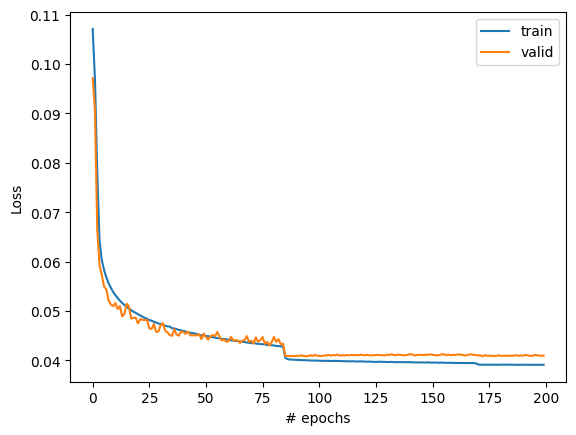

Finsh !  ! !


In [54]:
# Parameters
Z_flag = False
num_epochs = 200
K = 5 # Action size
N = 20 # Number of players
input_size = 9 * K
lr_init = 0.001
output_size = 3 * K
batch_size = 256
L= 1000000

# %% Read data and prepare to train
X_train = np.load("numpy_array_save/EST_(ABC)/X_train.npy")
Y_train = np.load("numpy_array_save/EST_(ABC)/Y_train.npy")


# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

# Split data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.05)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# %% Create the model, loss function, and optimizer:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Congestion(input_size=input_size, output_size=output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr_init, betas=(0.9, 0.999))
scheduler = StepLR(optimizer, step_size=85, gamma=0.1)

# %% Training loop:
train_list = []
valid_list = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, targets in train_loader:
        # Squeeze the input tensor to match the Fc size
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # Add my map label function
        new_outputs, new_targets = Map_loss_function(outputs, targets, K, outputs.shape[0], device)
        loss = criterion(new_outputs, new_targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    scheduler.step()  # Update the learning rate

    # Validate
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            # Add my map label function
            new_outputs, new_targets = Map_loss_function(outputs, targets, K, outputs.shape[0], device)
            loss = criterion(new_outputs, new_targets)
            val_loss += loss.item() * inputs.size(0)


    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_list.append(train_loss)
    valid_list.append(val_loss)
    lr_value = optimizer.param_groups[0]["lr"]
    print(f"Epoch [{epoch+1}/{num_epochs}] Learning Rate:{lr_value} - "
          f"Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}")

# %% Plot and save weights
# Plot results
epochs = np.arange(num_epochs)
plt.plot(epochs, train_list, label='train')
plt.plot(epochs, valid_list, label='valid')
plt.xlabel("# epochs"), plt.ylabel("Loss"), plt.legend()
plt.show()
# Save Network results
PATH = './ABC_est.pth'
torch.save(model.state_dict(), PATH)


print("Finsh !  ! !")

# Plot scatter train for debug

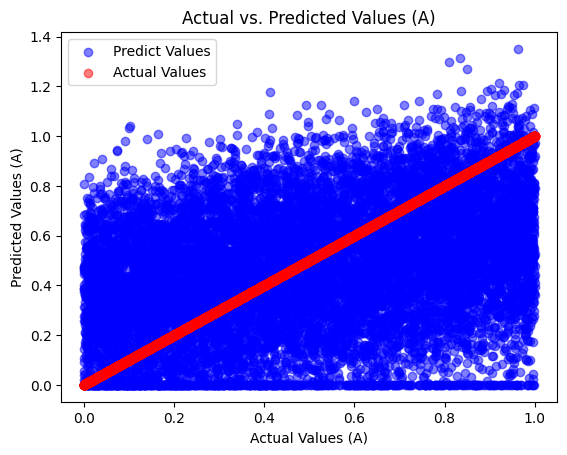

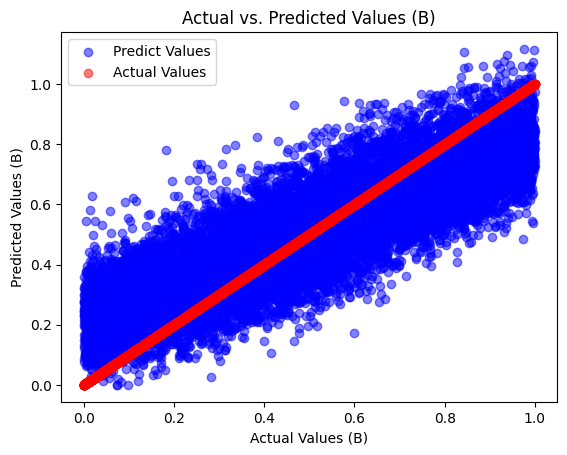

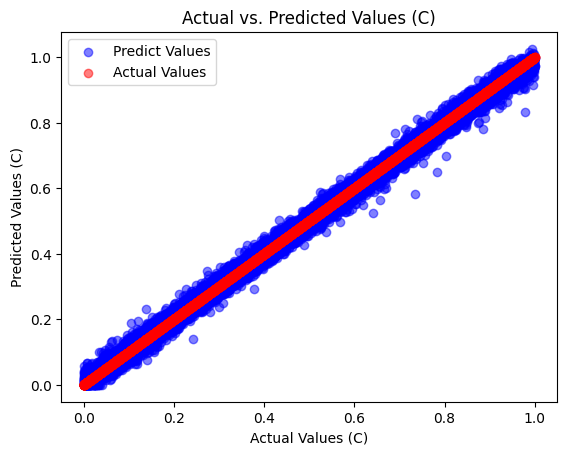

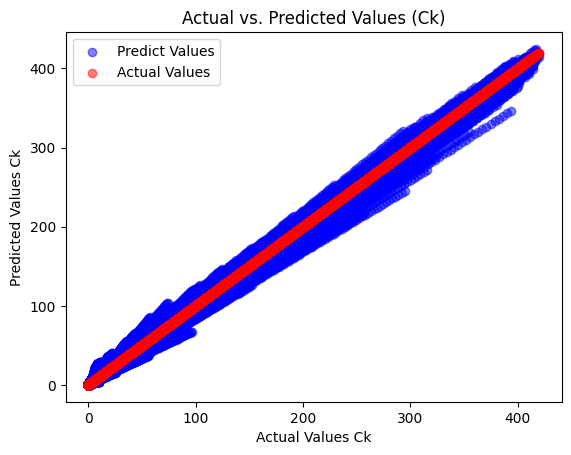

In [57]:
# %% Read data and prepare to train
X_train = np.load("numpy_array_save/EST_(ABC)/X_train.npy")
Y_train = np.load("numpy_array_save/EST_(ABC)/Y_train.npy")

# Take part ftom the data
X_train = X_train[0:2500, :]
Y_train = Y_train[0:2500, :]

# Debug Model
X_train_model = torch.tensor(X_train, dtype=torch.float32).to(device)


# Load model 
model = Congestion(input_size=input_size, output_size=output_size).to(device)
model.load_state_dict(torch.load("ABC_est(x=20).pth", map_location='cuda'))

# Take beta results
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
   outputs = model(X_train_model).to(device)
   z = outputs # add for Ck
   outputs = outputs.cpu().numpy()

A_EST = outputs[:, 0:K]
B_EST = outputs[:, K:(2*K)]
C_EST = outputs[:, (2*K):(3*K)]

A_LABELS = Y_train[:, 0:K]
B_LABELS = Y_train[:, K:(2*K)]
C_LABELS = Y_train[:, (2*K):(3*K)]
# I add for CK
z_targets = torch.tensor(Y_train, dtype=torch.float32).to(device)
new_outputs, new_targets = Map_loss_function(z, z_targets, K, outputs.shape[0], device)
new_outputs = new_outputs.cpu().numpy()
new_targets = new_targets.cpu().numpy()

plt.figure(1)
plt.scatter(A_LABELS.flatten(), A_EST.flatten(), c='blue', label='Predict Values', alpha=0.5)
plt.scatter(A_LABELS[:, 0:K].flatten(), A_LABELS[:, 0:K].flatten(), c='red', label='Actual Values', alpha=0.5)
plt.xlabel("Actual Values (A)")
plt.ylabel("Predicted Values (A)")
plt.title("Actual vs. Predicted Values (A)")
plt.legend()

plt.figure(2)
plt.scatter(B_LABELS.flatten(), B_EST.flatten(), c='blue', label='Predict Values', alpha=0.5)
plt.scatter(B_LABELS[:, 0:K].flatten(), B_LABELS[:, 0:K].flatten(), c='red', label='Actual Values', alpha=0.5)
plt.xlabel("Actual Values (B)")
plt.ylabel("Predicted Values (B)")
plt.title("Actual vs. Predicted Values (B)")
plt.legend()


plt.figure(3)
plt.scatter(C_LABELS.flatten(), C_EST.flatten(), c='blue', label='Predict Values', alpha=0.5)
plt.scatter(C_LABELS[:, 0:K].flatten(), C_LABELS[:, 0:K].flatten(), c='red', label='Actual Values', alpha=0.5)
plt.xlabel("Actual Values (C)")
plt.ylabel("Predicted Values (C)")
plt.title("Actual vs. Predicted Values (C)")
plt.legend()


plt.figure(4)
plt.scatter(new_targets.flatten(), new_outputs.flatten(), c='blue', label='Predict Values', alpha=0.5)
plt.scatter(new_targets.flatten(), new_targets.flatten(), c='red', label='Actual Values', alpha=0.5)
plt.xlabel("Actual Values Ck")
plt.ylabel("Predicted Values Ck")
plt.title("Actual vs. Predicted Values (Ck)")
plt.legend()

plt.show()
